In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing,linear_model
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from utils.readProfiles import *
from utils.pred_models import *
from yellowbrick.model_selection import FeatureImportances

sns.set_style("whitegrid")
# from utils import networksEvol, tsne, readProfiles
# import umap

##### create single blue colormap to change defualt colors in yellowbrick
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
blue_cmap = cm.get_cmap('Blues', 200)
single_blue_cmap=ListedColormap(blue_cmap(np.linspace(0.7, 0.9, 20)))

### In this notebook you can find your answer to these questions:


1. What CP features are related to your Gene under study?
2. What are the Genes invloved in predicting a CP feature?


* Due to quality of overall predictions as reported in the paper, we use:
   - **LINCS** dataset for chemical perturbation reference 
   - **LUAD** dataset for genetic perturbation reference 


## User input parameters

In [3]:
# In which perturbation context you want to explore your features
# "genetic" or "chemical"
which_dataset_to_use="genetic"

cp_features_under_test=['Cells_Texture_InfoMeas1_RNA_3_0']
# Cells_Texture_InfoMeas1_RNA_3_0,Cytoplasm_AreaShape_Zernike_9_3
ge_features_under_test=['CISD1']

#### Paths

In [4]:
# procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
results_dir='./results/'


## What are the CP features invloved in predicting a specific gene?

/home/ubuntu/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/utils/readProfiles.py:149: DtypeWarning: Columns (1814) have mixed types.Specify dtype option on import or set low_memory=False.
  [cp_data_repLevel,cp_features], [l1k_data_repLevel,l1k_features] = read_replicate_level_profiles(dataset_rootDir,dataset,profileType,per_plate_normalized_flag);
/home/ubuntu/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/utils/readProfiles.py:149: DtypeWarning: Columns (1023,1028,1032) have mixed types.Specify dtype option on import or set low_memory=False.
  [cp_data_repLevel,cp_features], [l1k_data_repLevel,l1k_features] = read_replicate_level_profiles(dataset_rootDir,dataset,profileType,per_plate_normalized_flag);


LUAD: Replicate Level Shapes (nSamples x nFeatures): cp:  6144 , 1569 ,  l1k:  4232 , 978
l1k n of rep:  8.0
cp n of rep:  8.0
CP: from  593  to  364
l1k: from  529  to  275
CP and l1k high rep overlap:  197
Treatment Level Shapes (nSamples x nFeatures+metadata): (198, 1570) (198, 979) Merged Profiles Shape: (198, 2548)


/home/ubuntu/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


CISD1


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


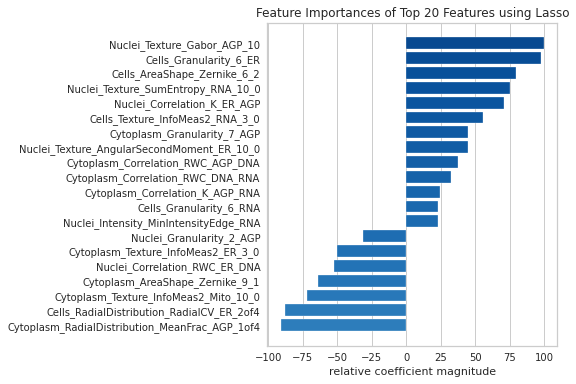

In [8]:
if which_dataset_to_use=="genetic":
    dataset='LUAD';
elif which_dataset_to_use=="chemical":
    dataset='LINCS';    


filter_perts='highRepOverlap'
repCorrFilePath='./results/RepCor/RepCorrDF.xlsx'

filter_repCorr_params=[filter_perts,repCorrFilePath]    
    
################################################
pertColName='PERT'

mergProf_treatLevel,cp_features,l1k_features = \
read_paired_treatment_level_profiles(procProf_dir,dataset,'normalized',filter_repCorr_params,1)


l1k=mergProf_treatLevel[[pertColName]+l1k_features]
cp=mergProf_treatLevel[[pertColName]+cp_features]


if dataset=='LINCS':     
    cp.loc[:,'Compounds']=cp.loc[:,'PERT'].str[0:13]
    l1k.loc[:,'Compounds']=l1k.loc[:,'PERT'].str[0:13]
else:
    cp.loc[:,'Compounds']=cp.loc[:,'PERT'].values
    l1k.loc[:,'Compounds']=l1k.loc[:,'PERT'].values


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))


if 1:
    cp=cp_scaled.copy()
    l1k=l1k_scaled.copy()

##############################

l1k,l1k_features_gn=rename_affyprobe_to_genename(l1k,l1k_features,'./idmap.xlsx')

for g in ge_features_under_test:
#     viz = FeatureImportances(linear_model.Lasso(),relative=True, topn=20)
#     viz = FeatureImportances(linear_model.Lasso(alpha=0.001), labels=l1k_features_gn, relative=False,topn=20)
    print(g)
#     model = linear_model.LinearRegression()
    model = linear_model.Lasso(alpha=0.02)
    model.fit(cp[cp_features],l1k[g])
# #     model = RandomForestClassifier(n_estimators=10),colormap=single_blue_cmap
#     viz = FeatureImportances(model,topn=20,colormap='coolwarm')    
    viz = FeatureImportances(model,topn=20,colormap=single_blue_cmap)    
    
    viz.fit(cp[cp_features],l1k[g])
    viz.show()


## What are the Genes invloved in predicting a CP feature?

/home/ubuntu/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/utils/readProfiles.py:149: DtypeWarning: Columns (1814) have mixed types.Specify dtype option on import or set low_memory=False.
  [cp_data_repLevel,cp_features], [l1k_data_repLevel,l1k_features] = read_replicate_level_profiles(dataset_rootDir,dataset,profileType,per_plate_normalized_flag);
/home/ubuntu/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/utils/readProfiles.py:149: DtypeWarning: Columns (1023,1028,1032) have mixed types.Specify dtype option on import or set low_memory=False.
  [cp_data_repLevel,cp_features], [l1k_data_repLevel,l1k_features] = read_replicate_level_profiles(dataset_rootDir,dataset,profileType,per_plate_normalized_flag);


LUAD: Replicate Level Shapes (nSamples x nFeatures): cp:  6144 , 1569 ,  l1k:  4232 , 978
l1k n of rep:  8.0
cp n of rep:  8.0
CP: from  593  to  364
l1k: from  529  to  275
CP and l1k high rep overlap:  197
Treatment Level Shapes (nSamples x nFeatures+metadata): (198, 1570) (198, 979) Merged Profiles Shape: (198, 2548)


/home/ubuntu/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Cells_Texture_InfoMeas1_RNA_3_0


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


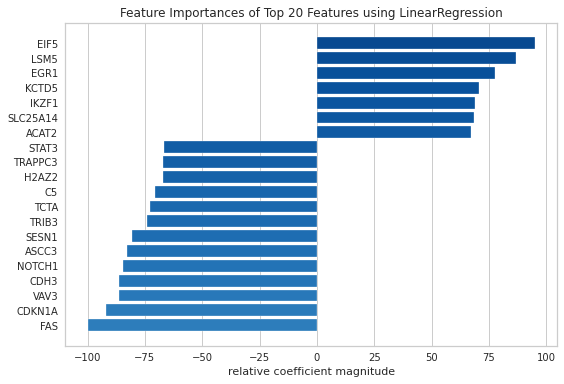

In [9]:
if which_dataset_to_use=="genetic":
    dataset='LUAD';
elif which_dataset_to_use=="chemical":
    dataset='LINCS';    

filter_perts='highRepOverlap'
repCorrFilePath='./results/RepCor/RepCorrDF.xlsx'

filter_repCorr_params=[filter_perts,repCorrFilePath]        

################################################
pertColName='PERT'

mergedProfiles_treatLevel,cp_features,l1k_features = \
read_paired_treatment_level_profiles(procProf_dir,dataset,'normalized',filter_repCorr_params,1)


l1k=mergedProfiles_treatLevel[[pertColName]+l1k_features]
cp=mergedProfiles_treatLevel[[pertColName]+cp_features]


if dataset=='LINCS':     
    cp.loc[:,'Compounds']=cp.loc[:,'PERT'].str[0:13]
    l1k.loc[:,'Compounds']=l1k.loc[:,'PERT'].str[0:13]
else:
    cp.loc[:,'Compounds']=cp.loc[:,'PERT'].values
    l1k.loc[:,'Compounds']=l1k.loc[:,'PERT'].values


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))


if 1:
    cp=cp_scaled.copy()
    l1k=l1k_scaled.copy()

##############################
# meta=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/affy_probe_gene_mapping.txt",delimiter="\t",header=None, names=["probe_id", "gene"])
# meta_gene_probID=meta.set_index('probe_id')
# d = dict(zip(meta_gene_probID.index, meta_gene_probID['gene']))
# l1k_features_gn=[d[l] for l in l1k_features]
# l1k = l1k.rename(columns=d)    

l1k,l1k_features_gn=rename_affyprobe_to_genename(l1k,l1k_features,'./idmap.xlsx')

    

for c in cp_features_under_test:
    print(c)
#     viz = FeatureImportances(linear_model.Lasso(),relative=True, topn=20)
#     viz = FeatureImportances(linear_model.Lasso(alpha=0.001), labels=l1k_features_gn, relative=False,topn=20)
    
    model = linear_model.LinearRegression()
    model.fit(l1k[l1k_features_gn],cp[c])
# #     model = RandomForestClassifier(n_estimators=10)

    viz = FeatureImportances(model,topn=20,colormap=single_blue_cmap,size=(260, 360),\
                             title="Top genes involved in\n prediction of feature\n'"+c+"'")    
    viz.fit(l1k[l1k_features_gn],cp[c]);
    viz.show()
#     viz.show(outpath='fig3c.pdf')

In [ ]:
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile
source_data_add='./Figs_Source_Data.xlsx'
source_data_fig3c=pd.DataFrame(np.stack([viz.features_,viz.feature_importances_],axis=1),\
                            columns=['Genes','RCM']).sort_values(by='RCM',ascending=False).reset_index(drop=True)
if 1:
    viz.show(outpath='fig3c.pdf')
    saveAsNewSheetToExistingFile(source_data_add,source_data_fig3c,'fig3c')

In [1]:
# fig, ax = plt.subplots(figsize=(3,5))
# ax.set_title('fdg')
# # viz = FeatureImportances(model,topn=20,ax=ax)
# # viz.show()
# model = linear_model.LinearRegression()
# model.fit(l1k[l1k_features_gn],cp[c])
# # #     model = RandomForestClassifier(n_estimators=10)
# viz = FeatureImportances(model,topn=20,ax=ax)    

# viz.fit(l1k[l1k_features_gn],cp[c])
# viz.show()

In [2]:
# pwd

In [102]:
# %matplotlib inline
# viz = FeatureImportances(model,topn=20,stack=False,colormap=single_blue_cmap,size=(220, 350))    
# viz.ax.set_xlim([-100,100])
# viz.fit(l1k[l1k_features_gn],cp[c])
# viz.show()